# PREP

In [1]:
import os
import numpy as np
import math
import pandas as pd
import re
from functools import reduce
from collections import OrderedDict
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score
)
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

2023-07-06 10:11:06.550320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/cv2/../../lib64:
2023-07-06 10:11:06.550337: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-06 10:11:07.753230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/cv2/../../lib64:
2023-07-06 10:11:07.753249: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-06 10:11:07.753263: I tensorflow/stream_executor/cuda

In [128]:
REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'
# REPODIR = '/home/wimmerl/projects/wildlife-experiments/'
RESULTDIR = os.path.join(REPODIR, 'results')

CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
EMPTY_CLASS = LABEL_MAP['empty']
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'display_labels': list(LABEL_MAP.keys()),
    'xticks_rotation': 45,
    'colorbar': False,
    'cmap': 'Blues',
}
CONFMAT_PLT_ARGS = {
    'figure.figsize': (6, 6),
    'font.size': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.alignment': 'right'
}
THRESHOLDS = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
ITERATIONS = list(range(9))[1:]
RANDOM_SEEDS = ['123', '456', '789']

## SET MD4 OR MD5

In [104]:
# SUFFIX_PKL = '.pkl'
# SUFFIX = ''
# OUR_THRESH = 0.5
SUFFIX_PKL = '_md5.pkl'
SUFFIX = 'md5'
OUR_THRESH = 0.1

## DATA

In [129]:
FILES_INSAMPLE = [
    [
        os.path.join(RESULTDIR, 'passive', t, f) for f in os.listdir(os.path.join(RESULTDIR, 'passive', t)) 
        if re.search(r'(insample_test_)+(\d+)' + re.escape(SUFFIX_PKL), f)
    ] 
    for t in [str(int(100 * ts)) for ts in THRESHOLDS]
]
FILES_OOSAMPLE = [
    os.path.join(RESULTDIR, 'passive', str(int(100 * OUR_THRESH)), f) 
    for f in os.listdir(os.path.join(RESULTDIR, 'passive', str(int(100 * OUR_THRESH)))) 
    if re.search(r'(oosample_)+(\d+)' + re.escape(SUFFIX_PKL), f)
]
FILES_ACTIVE_OPTIMAL = [
    os.path.join(RESULTDIR, 'active', 'optimal', f) 
    for f in os.listdir(os.path.join(RESULTDIR, 'active', 'optimal'))
    if re.search(r'(active_optimal_)+(\d+)' + re.escape(SUFFIX_PKL), f)
]
FILES_ACTIVE_COLDSTART = [
    os.path.join(RESULTDIR, 'active', 'coldstart', 'entropy', SUFFIX, rs) for rs in RANDOM_SEEDS
]
FILES_ACTIVE_WARMSTART = [
    os.path.join(RESULTDIR, 'active', 'warmstart', 'entropy', SUFFIX, rs) for rs in RANDOM_SEEDS
]

In [107]:
# RESULT_FILE = {**RESULTS_INSAMPLE_TEST_01, **RESULTS_INSAMPLE_TEST_05}
PREDS = 'preds_imgs_ppl'
TRUTH = 'truth_imgs_ppl'

In [108]:
def sort_results(dict_preds, truth):
    ordered_dict = {k: dict_preds[k] for k in sorted(list(dict_preds.keys()))}
    ordered_array = np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(ordered_dict.values())])
    ordered_list = [truth[k] for k in [list(dict_preds.keys()).index(i) for i in sorted(list(dict_preds.keys()))]]
    return ordered_array, ordered_list

# IN-SAMPLE

## PERFORMANCE ACROSS THRESHOLDS ON TEST

Using varying thresholds for the MD, how well is our pipeline able to 1) classify images overall, 2) detect empty images correctly?

In [130]:
rows_multiclass_avg, rows_multiclass_se = [], []
rows_empty_avg, rows_empty_se = [], []

for idx, t in enumerate(THRESHOLDS):
    
    results_t = [f for f in FILES_INSAMPLE[idx]]
    accs, precs, recs, fones = [], [], [], []
    accs_empty, precs_empty, recs_empty, fones_empty = [], [], [], []
    precs_nonempty, recs_nonempty, fones_nonempty = [], [], []
    
    for rt in results_t:
        
        r = load_pickle(rt)
        preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r[PREDS], r[TRUTH])
        y_true = truth_imgs_ppl_t
        y_pred = [np.argmax(v) for v in preds_imgs_ppl_t]
        report = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            zero_division=0,
            output_dict=True,
        )
        
        accs.append(report['accuracy'])
        precs.append(report['weighted avg']['precision'])
        recs.append(report['weighted avg']['recall'])
        fones.append(report['weighted avg']['f1-score'])
        
        conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
        tn, fp, fn, tp = conf_empty.ravel()
        accs_empty.append((tn + tp) / (tn + fp + fn + tp))
        precs_empty.append(report['empty']['precision'])
        recs_empty.append(report['empty']['recall'])
        fones_empty.append(report['empty']['f1-score'])
        precs_nonempty.append(tn / (tn + fn))
        recs_nonempty.append(tn / (tn + fp))
        fones_nonempty.append(2 * tn / (2 * tn + fn + fp))
        
    accs = np.array(accs)
    precs = np.array(precs)
    recs = np.array(recs)
    fones = np.array(fones)
    rows_multiclass_avg_t = [t]
    rows_multiclass_avg_t.extend(
        [np.round(x, 3) for x in [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)]]
    )
    rows_multiclass_avg.append(rows_multiclass_avg_t)
    rows_multiclass_se_t = [t]
    rows_multiclass_se_t.extend(
        [
            np.round(x, 3) for x in [
                np.std(accs) / math.sqrt(len(accs)),
                np.std(precs) / math.sqrt(len(precs)),
                np.std(recs) / math.sqrt(len(recs)),
                np.std(fones) / math.sqrt(len(fones))
            ]
            
        ]
        
    )
    rows_multiclass_se.append(rows_multiclass_se_t)
    accs_empty = np.array(accs_empty)
    precs_empty = np.array(precs_empty)
    recs_empty = np.array(recs_empty)
    fones_empty = np.array(fones_empty)
    precs_nonempty = np.array(precs_nonempty)
    recs_nonempty = np.array(recs_nonempty)
    fones_nonempty = np.array(fones_nonempty)
    rows_empty_avg_t = [t]
    rows_empty_avg_t.extend(
        [
            np.round(x, 3) for x in [
                np.mean(accs_empty), 
                np.mean(precs_empty), 
                np.mean(recs_empty), 
                np.mean(fones_empty),
                np.mean(precs_nonempty), 
                np.mean(recs_nonempty), 
                np.mean(fones_nonempty)                
            ]
        ]
    )
    rows_empty_avg.append(rows_empty_avg_t)
    rows_empty_se_t = [t]
    rows_empty_se_t.extend(
        [
            np.round(x, 3) for x in [
                np.std(accs_empty) / math.sqrt(len(accs_empty)),
                np.std(precs_empty) / math.sqrt(len(precs_empty)),
                np.std(recs_empty) / math.sqrt(len(recs_empty)),
                np.std(fones_empty) / math.sqrt(len(fones_empty)),
                np.std(precs_empty) / math.sqrt(len(precs_nonempty)),
                np.std(recs_empty) / math.sqrt(len(recs_nonempty)),
                np.std(fones_empty) / math.sqrt(len(fones_nonempty))
            ]
            
        ]
        
    )
    rows_empty_se.append(rows_empty_se_t)
COLNAMES = ['threshold', 'acc', 'prec', 'rec', 'fone']
COLNAMES_EMPTY = ['threshold', 'acc', 'prec', 'rec', 'fone', 'prec_ne', 'rec_ne', 'fone_ne']
df_ins_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_ins_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)
df_ins_empty_avg = pd.DataFrame(rows_empty_avg, columns=COLNAMES_EMPTY)
df_ins_empty_se = pd.DataFrame(rows_empty_se, columns=COLNAMES_EMPTY)

/home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/lisa-wm/miniconda2/envs/wildlife/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

In [131]:
df_ins_multiclass_avg  # Table 3

,threshold,acc,prec,rec,fone
0,0.0,NaN,NaN,NaN,NaN
1,0.1,0.933,0.928,0.933,0.929
2,0.3,0.931,0.926,0.931,0.927
3,0.5,0.924,0.919,0.924,0.918
4,0.7,0.906,0.903,0.906,0.897
5,0.9,0.805,0.825,0.805,0.773


In [132]:
df_ins_empty_avg  # Table 2

,threshold,acc,prec,rec,fone,prec_ne,rec_ne,fone_ne
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.962,0.950,0.993,0.971,0.986,0.906,0.944
2,0.3,0.959,0.946,0.994,0.969,0.987,0.899,0.941
3,0.5,0.947,0.927,0.996,0.960,0.991,0.861,0.922
4,0.7,0.927,0.898,0.998,0.946,0.996,0.799,0.887
5,0.9,0.816,0.777,0.999,0.874,0.997,0.491,0.658


## PERFORMANCE

In [133]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_INSAMPLE[1]]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
print(  # Figure 3
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
    )
)

               precision    recall  f1-score   support

        empty       0.95      0.99      0.97      9356
european_hare       0.87      0.71      0.78       256
       others       0.60      0.42      0.49       604
     red_deer       0.83      0.62      0.71        16
      red_fox       0.87      0.77      0.82       404
 red_squirrel       0.87      0.79      0.82       188
     roe_deer       0.94      0.91      0.93      3704
    wild_boar       0.76      0.74      0.75        96

     accuracy                           0.93     14624
    macro avg       0.84      0.74      0.79     14624
 weighted avg       0.93      0.93      0.93     14624



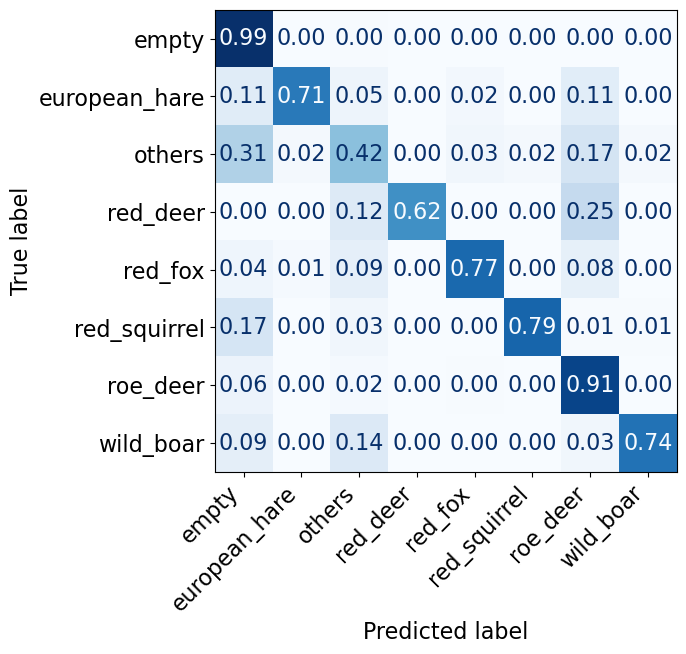

In [134]:
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
plt.rcParams.update(CONFMAT_PLT_ARGS)
plt.savefig(f'figures/cm_insample{SUFFIX}.eps', bbox_inches='tight')
plt.savefig(f'figures/cm_insample{SUFFIX}.png', bbox_inches='tight')

# OUT-OF-SAMPLE

## PERFORMANCE

In [135]:
rows_multiclass_avg, rows_multiclass_se = [], []
accs, precs, recs, fones = [], [], [], []

for r in [f for f in FILES_OOSAMPLE]:
    r = load_pickle(r)
    preds_imgs_ppl, truth_imgs_ppl = sort_results(r[PREDS], r[TRUTH])
    y_true = truth_imgs_ppl
    y_pred = [np.argmax(v) for v in preds_imgs_ppl]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )
    accs.append(report['accuracy'])
    precs.append(report['weighted avg']['precision'])
    recs.append(report['weighted avg']['recall'])
    fones.append(report['weighted avg']['f1-score'])
accs = np.array(accs)
precs = np.array(precs)
recs = np.array(recs)
fones = np.array(fones)
rows_multiclass_avg.append([np.round(x, 3) for x in [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)]])
rows_multiclass_se.append(
    [
        np.round(x, 3) for x in [
            np.std(accs) / math.sqrt(len(accs)),
            np.std(precs) / math.sqrt(len(precs)),
            np.std(recs) / math.sqrt(len(recs)),
            np.std(fones) / math.sqrt(len(fones))
        ]
        
    ]

)
COLNAMES = ['acc', 'prec', 'rec', 'fone']
df_oos_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_oos_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)

In [136]:
acc_al_lower_limit, rec_al_lower_limit = rows_multiclass_avg[0][0], rows_multiclass_avg[0][1]

In [138]:
df_multiclass_avg = pd.concat(
    [df_ins_multiclass_avg.loc[df_ins_multiclass_avg['threshold'] == OUR_THRESH], df_oos_multiclass_avg]
)
df_multiclass_avg.index = ['ins', 'oos']

In [139]:
df_multiclass_se = pd.concat(
    [df_ins_multiclass_se.loc[df_ins_multiclass_se['threshold'] == OUR_THRESH], df_oos_multiclass_se]
)
df_multiclass_se.index = ['ins', 'oos']

In [140]:
df_multiclass_avg.drop(['threshold'], axis=1)  # Table 5

,acc,prec,rec,fone
ins,0.933,0.928,0.933,0.929
oos,0.868,0.874,0.868,0.867


In [141]:
df_multiclass_se.drop(['threshold'], axis=1)

,acc,prec,rec,fone
ins,0.000,0.000,0.000,0.000
oos,0.001,0.003,0.001,0.002


In [142]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_OOSAMPLE]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))

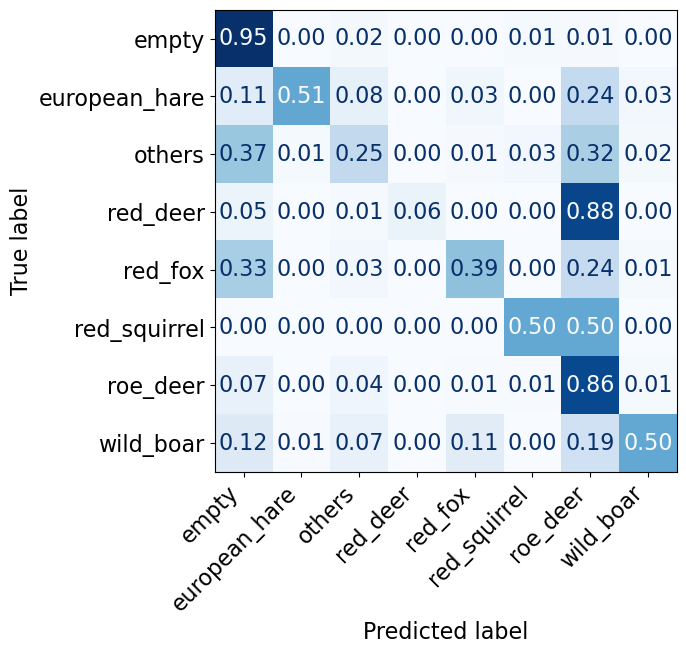

In [143]:
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
plt.rcParams.update(CONFMAT_PLT_ARGS)
plt.savefig(f'figures/cm_oosample{SUFFIX}.eps', bbox_inches='tight')
plt.savefig(f'figures/cm_oosample{SUFFIX}.png', bbox_inches='tight')

## ACTIVE LEARNING

In [144]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_ACTIVE_OPTIMAL]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
report_dict = classification_report(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds),
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
acc_al_upper_limit, rec_al_upper_limit = report_dict['accuracy'], report_dict['weighted avg']['precision']

In [145]:
print(  # Figure 5
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 

               precision    recall  f1-score   support

        empty       0.93      0.99      0.96      6384
european_hare       0.94      0.61      0.74       111
       others       0.73      0.43      0.54       438
     red_deer       0.91      0.50      0.65        60
      red_fox       0.84      0.47      0.61        57
 red_squirrel       1.00      0.50      0.67         6
     roe_deer       0.95      0.92      0.93      3225
    wild_boar       0.95      0.82      0.88       408

     accuracy                           0.93     10689
    macro avg       0.91      0.66      0.75     10689
 weighted avg       0.93      0.93      0.93     10689



In [160]:
# compute relative sample size per iteration (sizes hard-coded for training)
n_obs = 10020
init_batches = [0] + [2**x for x in range(7, 11)] # !!
batch_sizes = init_batches + [n_obs - sum(init_batches)]
batch_sizes_cs = np.cumsum([x / n_obs for x in batch_sizes])

In [161]:
batch_sizes

[0, 128, 256, 512, 1024, 8100]

In [162]:
ITERATION_EXTRACT = 6

{'empty': {'precision': 0.931874908236676, 'recall': 0.994204260651629, 'f1-score': 0.9620310723759, 'support': 6384}, 'european_hare': {'precision': 0.9178082191780822, 'recall': 0.6036036036036037, 'f1-score': 0.7282608695652173, 'support': 111}, 'others': {'precision': 0.6920289855072463, 'recall': 0.4360730593607306, 'f1-score': 0.5350140056022409, 'support': 438}, 'red_deer': {'precision': 0.9142857142857143, 'recall': 0.5333333333333333, 'f1-score': 0.6736842105263158, 'support': 60}, 'red_fox': {'precision': 0.8055555555555556, 'recall': 0.5087719298245614, 'f1-score': 0.6236559139784946, 'support': 57}, 'red_squirrel': {'precision': 0.75, 'recall': 0.5, 'f1-score': 0.6, 'support': 6}, 'roe_deer': {'precision': 0.9520414776409591, 'recall': 0.9110077519379844, 'f1-score': 0.9310727301536998, 'support': 3225}, 'wild_boar': {'precision': 0.9184782608695652, 'recall': 0.8284313725490197, 'f1-score': 0.8711340206185568, 'support': 408}, 'accuracy': 0.9303957339320797, 'macro avg': {

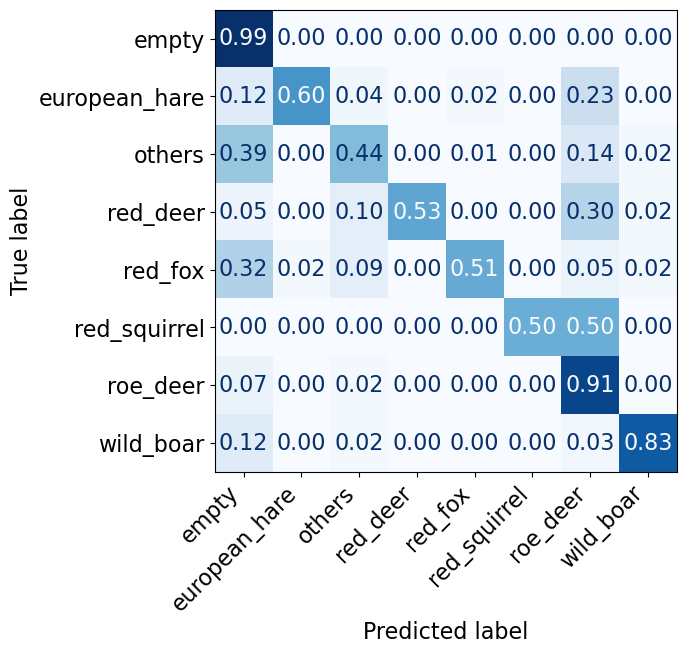

In [167]:
acc_coldstart_avg, rec_coldstart_avg = [], []
acc_coldstart_se, rec_coldstart_se = [], []
acc_warmstart_avg, rec_warmstart_avg = [], []
acc_warmstart_se, rec_warmstart_se = [], []

for i in ITERATIONS[:-2]: # !!
    acc_coldstart, rec_coldstart = [], []
    acc_warmstart, rec_warmstart = [], []
    y_trues, y_preds = np.empty(0), np.empty(0)
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_COLDSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS)
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_cs = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            output_dict=True,
            zero_division=0
        )
        acc_coldstart.append(report_dict_cs['accuracy'])
        rec_coldstart.append(report_dict_cs['weighted avg']['precision'])
        if i == ITERATION_EXTRACT:
            y_trues = np.concatenate((y_trues, y_true))
            y_preds = np.concatenate((y_preds, y_pred))
    if i == ITERATION_EXTRACT:
        ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
        plt.rcParams.update(CONFMAT_PLT_ARGS)
        plt.savefig('figures/cm_active.eps', bbox_inches='tight')
        plt.savefig('figures/cm_active.png', bbox_inches='tight')
        print(
            classification_report(
                y_true=y_trues, 
                y_pred=y_preds,
                target_names=list(LABEL_MAP.keys()),
                output_dict=True,
                zero_division=0
            )
        )
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_WARMSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS)
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_ws = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            output_dict=True,
            zero_division=0
        )
        acc_warmstart.append(report_dict_ws['accuracy'])
        rec_warmstart.append(report_dict_ws['weighted avg']['precision'])
    acc_coldstart = np.array(acc_coldstart)
    rec_coldstart = np.array(rec_coldstart)
    acc_coldstart_avg.append(np.mean(acc_coldstart))
    rec_coldstart_avg.append(np.mean(rec_coldstart))
    acc_coldstart_se.append(np.std(acc_coldstart) / math.sqrt(len(acc_coldstart)))
    rec_coldstart_se.append(np.std(rec_coldstart) / math.sqrt(len(rec_coldstart)))
    acc_warmstart = np.array(acc_warmstart)
    rec_warmstart = np.array(rec_warmstart)
    acc_warmstart_avg.append(np.mean(acc_warmstart))
    rec_warmstart_avg.append(np.mean(rec_warmstart))
    acc_warmstart_se.append(np.std(acc_warmstart) / math.sqrt(len(acc_warmstart)))
    rec_warmstart_se.append(np.std(rec_warmstart) / math.sqrt(len(rec_warmstart)))        

In [168]:
acc_coldstart_avg[-1] = acc_al_upper_limit
acc_warmstart_avg[-1] = acc_al_upper_limit
acc_coldstart_se[-1] = 0
acc_warmstart_se[-1] = 0

In [169]:
# create data for plot
al_perf_acc = {
    'relative_size': batch_sizes_cs,
    'acc_lower_limit': [acc_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'acc_upper_limit': [acc_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'acc_coldstart': acc_coldstart_avg,
    'se_coldstart': acc_coldstart_se,
    'acc_warmstart': acc_warmstart_avg,
    'se_warmstart': acc_warmstart_se,
}
al_perf_rec = {
    'relative_size': batch_sizes_cs,
    'rec_lower_limit': [rec_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'rec_upper_limit': [rec_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'rec_coldstart': rec_coldstart_avg,
    'rec_coldstart_se': rec_coldstart_se,
    'rec_warmstart': rec_warmstart
}

In [170]:
al_perf_acc

{'relative_size': array([0.        , 0.01277445, 0.03832335, 0.08942116, 0.19161677,
        1.        ]),
 'acc_lower_limit': [0.868, 0.868, 0.868, 0.868, 0.868, 0.868],
 'acc_upper_limit': [0.9318925998690243,
  0.9318925998690243,
  0.9318925998690243,
  0.9318925998690243,
  0.9318925998690243,
  0.9318925998690243],
 'acc_coldstart': [0.8714566376648891,
  0.8984002245298907,
  0.9067265413041445,
  0.919917672373468,
  0.9265600149686594,
  0.9318925998690243],
 'se_coldstart': [0.0035079676787824186,
  0.002256962874322144,
  0.0031094139855961335,
  0.0018726410073910712,
  0.001796304091298189,
  0],
 'acc_warmstart': [0.8815604827392646,
  0.9004584151931893,
  0.9069136495462625,
  0.919543455889232,
  0.9273084479371315,
  0.9318925998690243],
 'se_warmstart': [0.0024503322768657013,
  0.002151066749116616,
  0.0011858392329704452,
  0.0018912438581789822,
  0.000916639439716778,
  0]}

In [171]:
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
# al_perf_rec_pd = pd.DataFrame(al_perf_rec)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


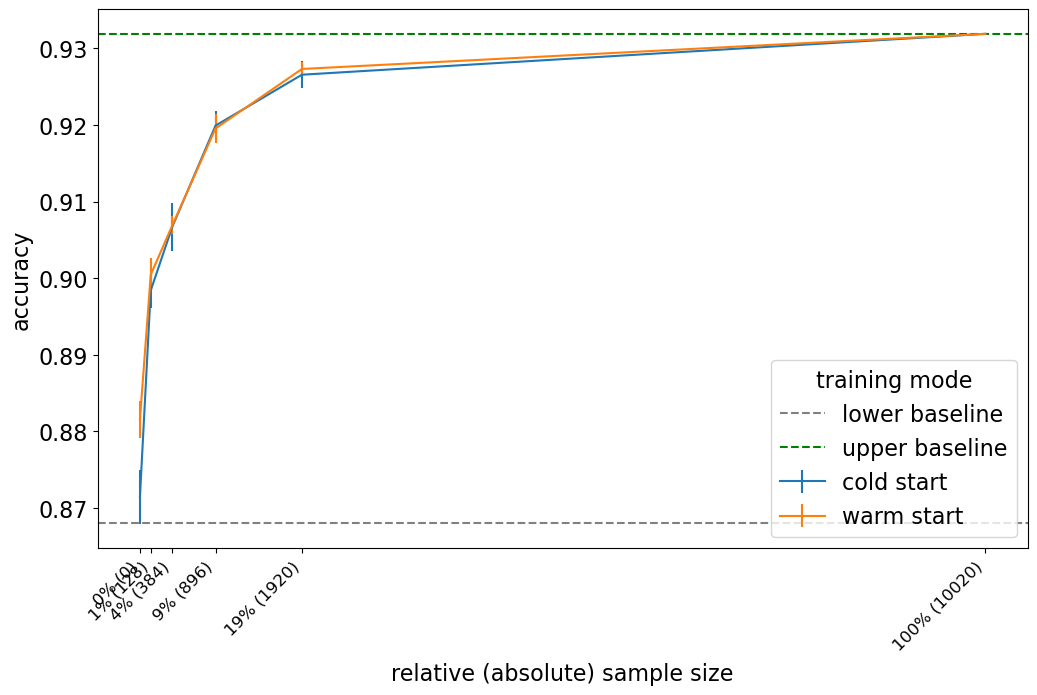

In [173]:
fig, ax = plt.subplots()
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_coldstart'], al_perf_acc_pd['se_coldstart'])
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_warmstart'], al_perf_acc_pd['se_warmstart'])
ax.set_xlabel('relative (absolute) sample size')
ax.set_xticks(al_perf_acc_pd['relative_size'])
dataset_sizes = [
    f' {round(i * 100)}% ({round(j)})' for i, j in zip(al_perf_acc_pd['relative_size'], np.cumsum(batch_sizes))
]
ax.set_xticklabels(dataset_sizes, rotation=45, ha='right')
ax.set_ylabel('accuracy')
# ax2 = ax.twiny()
# ax2.set_xticks(al_perf_acc_pd['relative_size'])
# ax2.set_xticklabels(batch_sizes, rotation=45)
# ax2.set_xlabel('absolute sample size')
# ax.set_xscale('log')
ax.axhline(acc_al_lower_limit,color='gray',ls='--')
ax.axhline(acc_al_upper_limit,color='green',ls='--')
ax.legend(
    title='training mode', 
    loc='lower right', 
    labels=['lower baseline', 'upper baseline', 'cold start', 'warm start']
)
plt_args = {
    'figure.figsize': (12, 7),
    'font.size': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 16,
    'xtick.alignment': 'right'
}
plt.rcParams.update(plt_args)
plt.savefig(f'figures/active_learning{SUFFIX}.eps', bbox_inches='tight')
plt.savefig(f'figures/active_learning{SUFFIX}.png', bbox_inches='tight')